# Predicting TCR Specificity Using Gaussian Processes
_Project by Santeri Mentu and Esa Turkulainen under the supervision of Emmi Jokinen_

## Introduction

T cells are the immune system cells primarily responsible for the detection and elimination of cells that are infected with viruses or other antigens. In order to mount an immune response, T cell receptors must recognize the foreign antigen being presented by infected cells. This mechanism determines much of the cell-mediated adaptive immune response, and is therefore of interest in the diagnosis and treatment of various diseases and disorders. Our aim was to model and predict this specificity by sequencing the amino acid sequences making up the TCR and using a machine learning technique called Gaussian processes to predict epitope specificity.
<figure>
  <img src="img/TCR_render.png" alt="Drawing" style="width:60%;"/>
  <figcaption>Fig.1 - Rendering of a TCR binding to a pMHC.</figcaption>
</figure>

## Gaussian processes

This covariance matrix is constructed using a covariance function, or kernel, which gives a measure of similarity between points. Different kernels result in different properties to the family of functions defined by the Gaussian process. The above figure shows examples of GPs with different kernel functions. We experimented with using a radial basis function (RBF) or squared exponential kernel, a rational quadratic kernel, and Matern kernels. 

The RBF kernel is defined as

$$k_{\text{RBF}}(\mathbf x, \mathbf x' | \theta) = \sigma^2 \left(- \frac{(\mathbf x - \mathbf x')^T(\mathbf x - \mathbf x')}{2l^2}\right),$$

where $\sigma$ is the magnitude hyperparameter and $l$ is the lengthscale hyperparameter. A high lengthscale means that the variable has weak predictive power. The rational quadratic kernel is defined as

$$k_{\text{RQ}}(r) = \left(1 + \frac{r^2}{2\alpha l^2}\right)^{-\alpha},$$

where $r$ is the euclidean distance between the inputs, and $l$ and $\alpha$ are hyperparameters. The Matern kernel is defined as

$$ k_{\text{Matern }}(r) = \frac{2^{1-v}}{\Gamma(v)}\left(\frac{\sqrt{2v} r}{l}\right)^v K_v \left(\frac{\sqrt{2v} r}{l}\right),$$

where $v$ and $l$ are hyperparameters. The parameter $v$ takes values $v = p + 1/2, p \in \mathbb N^+$, so the Matern kernels are commonly named Matern12 for $v = 1/2$, Matern32 for $v = 3/2$, and so on. The different kernels all have the effect of making samples close to each other in the feature space have similar epitope specificities, but different kernels result in different shapes for the fall-off.

Training the models is done by optimizing the model hyperparameters such that we minimize the marginal likelihood

$$p(\mathbf y | \mathbf{\theta}) = \int p(\mathbf y|\mathbf f)p(\mathbf f|\mathbf \theta) \text{d \textbf f},$$

where $\theta$ are model parameters, such as lengthscales of the kernel.

Gaussian processes are an example of nonparametric lazy learning methods, so the model is only evaluated during posterior prediction. However, this has complexity $\mathcal O(n^3)$, so we use some sort of approximation such as Laplace approximations, or in our case, sparse variational GPs. Sparse variational methods employ introduce $M$ fiducial points at optimized locations of the feature space, which results in a computational complexity of $\mathcal O(NM ^2)$ 

## Data
We used epitope and tcr data that can be accessed from [VDJdb](https://vdjdb.cdr3.net/). The specific dataset we used had been adapted for the task by Emmi Jokinen and is available from the [TCRGP github](https://github.com/emmijokinen/TCRGP).

## Loading the data

In [34]:
import sys
import pickle
import gpflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import os
from scipy.cluster.vq import kmeans
from sklearn.metrics import roc_auc_score, roc_curve
from IPython.display import display, clear_output
%matplotlib inline

# assuming that the TCRGP repo is located in the same directory as this project
sys.path.append('../TCRGP/')
import tcrgp

plt.style.use('ggplot')

In [42]:
data='vdj_human_ATDALMTGY' # Change this accordingly
#data='vdj_human_TPRVTGGGAM'

filename='{}.csv'.format(data)
datapath = os.path.join('.', 'training_data', filename)

In [43]:
df = pd.read_csv(datapath) # Create df to store data
n_samples = len(df.epitope) - 1

In [44]:
df.head() # Check that everything has loaded properly

,epitope,subject,va,vb,cdr3a,cdr3b
0,ATDALMTGY,PMID:21160049_D#8,NaN,TRBV10-3*01,NaN,CAISESQGNTEAFF
1,ATDALMTGY,PMID:21160049_D#10,NaN,TRBV10-3*01,NaN,CAISEDRALVSYTF
2,ATDALMTGY,PMID:21160049_D#8,NaN,TRBV10-3*01,NaN,CAISEDRALNEQFF
3,ATDALMTGY,PMID:21160049_D#8,NaN,TRBV10-3*01,NaN,CAVQPGQGMQPQHF
4,ATDALMTGY,PMID:21160049_D#3,NaN,TRBV10-3*01,NaN,CAISDGTVNNQPQHF


## Feature representation

In [45]:
def compute_kmers(string, n):
    """Returns a list of all the kmers of specified list that are present in a string"""
    return sorted(list(set([string[i: i+n] for i in range(len(string) - n + 1)])))

long_block = ''.join(df['cdr3b'])

# we use kmers of length 3
unique_kmers = compute_kmers(long_block, 3)

# Create feature vectors and labels
X = np.array([list(map(lambda kmer: float(kmer in sample), unique_kmers)) for sample in df['cdr3b']])
y = np.array([int(subject != 'control') for subject in df['subject']]).reshape(-1, 1)

In [46]:
# Define function for determining lengthscales
def compute_lengthscales(X, y, dims, kernel):
    
    n_samples = X.shape[0]

    with tf.Session(graph=tf.Graph()):
        if kernel_name == 'RBF':
            kernel = gpflow.kernels.RBF(input_dim=dims, ARD=True)
        elif kernel_name == 'Matern52':
            kernel = gpflow.kernels.Matern52(input_dim=dims, ARD=True)
        elif kernel_name == 'Matern32':
            kernel = gpflow.kernels.Matern32(input_dim=dims, ARD=True)
        elif kernel_name == 'Matern12':
            kernel = gpflow.kernels.Matern12(input_dim=dims, ARD=True)
        elif kernel_name == 'RationalQuadratic':
            kernel = gpflow.kernels.RationalQuadratic(input_dim=dims, ARD=True)
        else:
            raise Exception('{} is not a valid kernel name'.format(kernel_name))
        Z = kmeans(X, n_samples)[0] 
        m = gpflow.models.SVGP(X,y,kernel,gpflow.likelihoods.Bernoulli(), Z=Z)
        
       
        gpflow.train.AdamOptimizer().minimize(m, maxiter=1000)

    return kernel.lengthscales.value

## LOSO validation

In [8]:
subject_counts = df['subject'].value_counts().to_frame()[1:]
valid_subjects = subject_counts[subject_counts['subject'] > 10]

In [9]:
valid_subjects

,subject
PMID:25339770_p2,19
PMID:24512815_47-5022,19
PMID:22210916_subject4,17
PMID:21555537_pool_3,17
PMID:25339770_p1,15


In [10]:
subject_names = list(valid_subjects.index)

In [11]:
control_indices = np.where(df['subject'] == 'control')[0]
np.random.shuffle(control_indices)

pseudosubject_indices = np.split(control_indices, np.cumsum(valid_subjects['subject']))

In [12]:
pseudosubject_file = 'pseudosubjects_{}'.format(data)
with open(pseudosubject_file, 'wb+') as f:
    pickle.dump(pseudosubject_indices, f)

In [13]:
kernels = ['RationalQuadratic']

dimses = [600]

running LOSO for kernel RationalQuadratic with 600 dims
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


AUC score for PMID:25339770_p2 with 600 dims is: 0.6232686980609418
AUC score for PMID:24512815_47-5022 with 600 dims is: 0.8060941828254846
AUC score for PMID:22210916_subject4 with 600 dims is: 0.6539792387543252
AUC score for PMID:21555537_pool_3 with 600 dims is: 0.7024221453287198
AUC score for PMID:25339770_p1 with 600 dims is: 0.9333333333333333
CPU times: user 2min 46s, sys: 28.5 s, total: 3min 15s
Wall time: 3min 29s


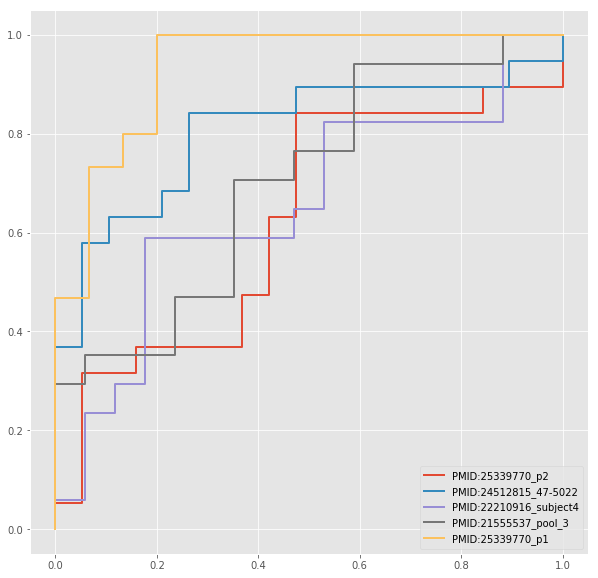

In [14]:
%%time

n_subjects = len(valid_subjects)

# we perform a hyperparameter search with different kernels and feature dimensions
# all runs use the same pseudosubjects in order to be comparable

for kernel_name in kernels:
    for dims in dimses:
    
        AUC_scores = {}
        fig, ax = plt.subplots(figsize=(10, 10))
        
        print('running LOSO for kernel {} with {} dims'.format(kernel_name, dims))
        
        for (name, pseudo_ids) in zip(subject_names, pseudosubject_indices):

            subject_index = np.where(df['subject'] == name)[0]

            #print(len(subject_index))
            #print(len(pseudo_ids))

            validation_indices = np.union1d(subject_index, pseudo_ids)

            X_train = np.delete(X, validation_indices, axis = 0)
            y_train = np.delete(y, validation_indices, axis = 0)

            X_validation = X[validation_indices]
            y_validation = y[validation_indices]

            n_samples = len(y_train)

            #print(X_train.shape)
            #print(y_train.shape)

            # compute the ARD lengthscales for the test samples
            lengthscales = compute_lengthscales(X_train, y_train, dims=X.shape[1], kernel=kernel_name)
            
            top_indices = np.argsort(np.abs(lengthscales))[0:dims]

            with tf.Session(graph=tf.Graph()):
                if kernel_name == 'RBF':
                    kernel = gpflow.kernels.RBF(input_dim=dims, ARD=True)
                elif kernel_name == 'Matern52':
                    kernel = gpflow.kernels.Matern52(input_dim=dims, ARD=True)
                elif kernel_name == 'Matern32':
                    kernel = gpflow.kernels.Matern32(input_dim=dims, ARD=True)
                elif kernel_name == 'Matern12':
                    kernel = gpflow.kernels.Matern12(input_dim=dims, ARD=True)
                elif kernel_name == 'RationalQuadratic':
                    kernel = gpflow.kernels.RationalQuadratic(input_dim=dims, ARD=True)
                else:
                    raise Exception('{} is not a valid kernel name'.format(kernel_name))
                Z = kmeans(X_train, n_samples)[0] 
                m = gpflow.models.SVGP(X_train,y_train,kernel,gpflow.likelihoods.Bernoulli(), Z=Z)
                gpflow.train.AdamOptimizer().minimize(m, maxiter=600)

                y_p = m.predict_y(X_validation)

            #print(y_validation)
            #print(y_p[0])

            predictions = y_p[0].reshape(-1)

            rocx, rocy, _ = roc_curve(y_validation, predictions, drop_intermediate=False)
            score = roc_auc_score(y_validation, predictions)
            print('AUC score for {} with {} dims is: {}'.format(name, dims, score))

            AUC_scores[name] = score

            ax.plot(rocx, rocy, lw=2, label=name)

        file_string = 'AUC_scores_dim{}_kernel_{}_{}'.format(dims, kernel_name, data)

        with open(file_string, 'wb+') as f:
                    pickle.dump(AUC_scores, f)
        
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        ax.legend()
        plt.savefig(fname=file_string)
        #plt.show()

In [15]:
for kernel_name in kernels:
    for dims in dimses:

        file_string = 'AUC_scores_dim{}_kernel_{}_{}'.format(dims, kernel_name, data)

        with open(file_string, 'rb') as f:
            AUC_scores = pickle.load(f)
        
        # print('LOSO results for kernel {} with {} dims'.format(kernel_name, dims))
        # print(AUC_scores)
        
        average = np.mean(list(AUC_scores.values()))
        
        print('mean AUC for kernel {} and dims {} is: \t {}'.format(kernel_name, dims, average))

mean AUC for kernel RationalQuadratic and dims 600 is: 	 0.743819519660561


mean AUC for subject ATDALMTGY is: 	 0.7854445127296031
mean AUC for subject TPRVTGGGAM is: 	 0.743819519660561
mean AUC for subject RAKFKQLL is: 	 0.7997254376538562
mean AUC for subject NLVPMVATV is: 	 0.6841325472063765


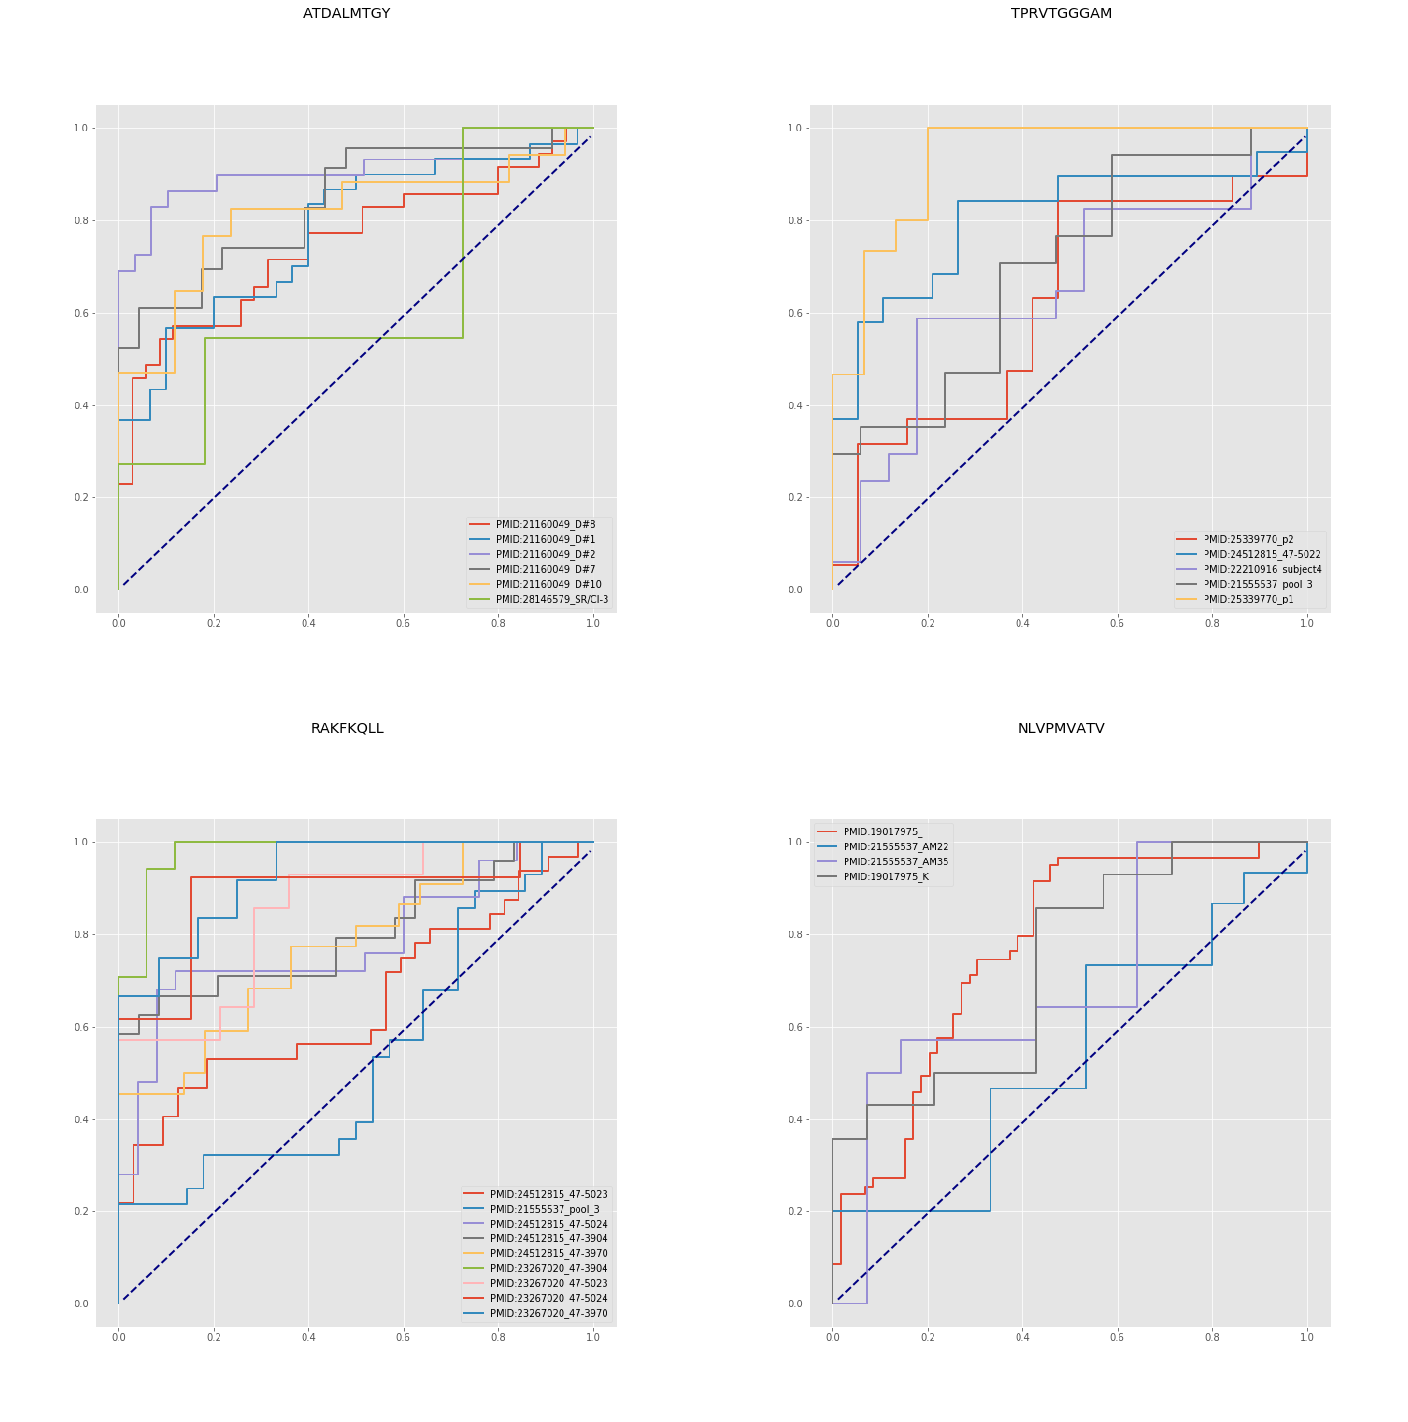

In [125]:
import matplotlib.image as mpimg

files = ['ATDALMTGY',
         'TPRVTGGGAM',
         'RAKFKQLL',
         'NLVPMVATV']

fig, axes = plt.subplots(2,2, figsize=(20, 20))

plt.gcf().tight_layout()

for file, ax in zip(files, axes.flatten()):
    
    score_file = 'AUC_scores_dim600_kernel_RationalQuadratic_vdj_human_{}'.format(file)
    
    with open(score_file, 'rb') as f:
        AUC_scores = pickle.load(f)
    
    average = np.mean(list(AUC_scores.values()))
        
    print('mean AUC for subject {} is: \t {}'.format(file, average))
    
    file_string = './img/AUC_scores_dim600_kernel_RationalQuadratic_vdj_human_{}.png'.format(file)
    
    img=mpimg.imread(file_string)
    
    ax.set_title('{}'.format(file))
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    
    ax.imshow(img)
    
plt.savefig('grid_figure.pdf')
plt.show()
         

## Multiple k-mers in learning

In [100]:
#data='vdj_human_ATDALMTGY' # Change this accordingly
data='vdj_human_NLVPMVATV'

filename='{}.csv'.format(data)
datapath = os.path.join('.', 'training_data', filename)

In [101]:
df = pd.read_csv(datapath) # Create df to store data
n_samples = len(df.epitope) - 1

In [102]:
long_block = ''.join(df['cdr3b'])

# we use kmers of length 3
three_mers = compute_kmers(long_block, 3)
four_mers = compute_kmers(long_block, 4)

# Create feature vectors and labels
X_three = np.array([list(map(lambda kmer: float(kmer in sample), three_mers)) for sample in df['cdr3b']])
X_four = np.array([list(map(lambda kmer: float(kmer in sample), four_mers)) for sample in df['cdr3b']])
y = np.array([int(subject != 'control') for subject in df['subject']]).reshape(-1, 1)

print(X_three.shape)
print(X_four.shape)

(826, 1788)
(826, 3415)


In [103]:
subject_counts = df['subject'].value_counts().to_frame()[1:]
valid_subjects = subject_counts[subject_counts['subject'] > 10]

subject_names = list(valid_subjects.index)

valid_subjects

,subject
PMID:19017975_,59
PMID:21555537_AM22,15
PMID:21555537_AM35,14
PMID:19017975_K,14


In [104]:
control_indices = np.where(df['subject'] == 'control')[0]
np.random.shuffle(control_indices)

pseudosubject_indices = np.split(control_indices, np.cumsum(valid_subjects['subject']))

AUC score for PMID:19017975_ with 600 dims is: 0.8024992818155702
AUC score for PMID:21555537_AM22 with 600 dims is: 0.6177777777777778
AUC score for PMID:21555537_AM35 with 600 dims is: 0.653061224489796
AUC score for PMID:19017975_K with 600 dims is: 0.75
CPU times: user 19min 53s, sys: 4min 32s, total: 24min 25s
Wall time: 32min 51s


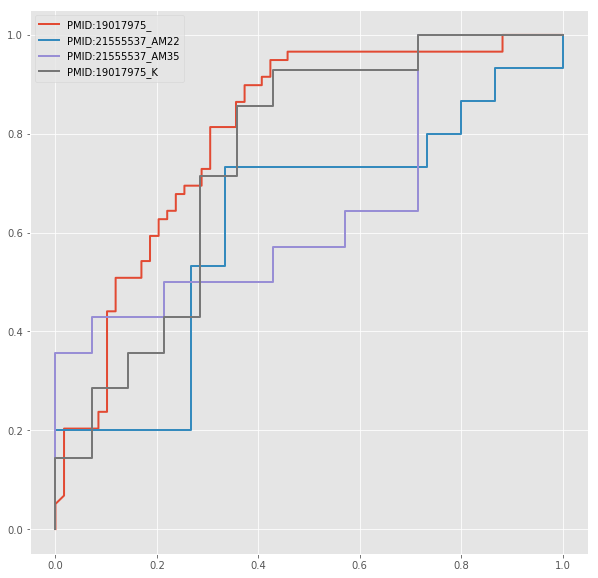

In [105]:
%%time

n_subjects = len(valid_subjects)

dims = 600

# we perform a hyperparameter search with different kernels and feature dimensions
# all runs use the same pseudosubjects in order to be comparable
    
AUC_scores = {}
fig, ax = plt.subplots(figsize=(10, 10))

kernel_name = 'RationalQuadratic'

#print('running LOSO for kernel {} with {} dims'.format(kernel_name, dims))

for (name, pseudo_ids) in zip(subject_names, pseudosubject_indices):

    subject_index = np.where(df['subject'] == name)[0]

    #print(len(subject_index))
    #print(len(pseudo_ids))

    validation_indices = np.union1d(subject_index, pseudo_ids)

    X_three_train = np.delete(X_three, validation_indices, axis = 0)
    X_four_train = np.delete(X_four, validation_indices, axis = 0)
    y_train = np.delete(y, validation_indices, axis = 0)

    X_three_validation = X_three[validation_indices]
    X_four_validation = X_four[validation_indices]
    y_validation = y[validation_indices]

    n_samples = len(y_train)

    #print(X_train.shape)
    #print(y_train.shape)

    # compute the ARD lengthscales for the test samples
    lengthscales_three = compute_lengthscales(X_three_train, y_train, dims=X_three.shape[1], kernel=kernel_name)
    lengthscales_four = compute_lengthscales(X_four_train, y_train, dims=X_four.shape[1], kernel=kernel_name)

    top_indices_three = np.argsort(np.abs(lengthscales_three))[0:dims]
    top_indices_four = np.argsort(np.abs(lengthscales_four))[0:dims]
    

    with tf.Session(graph=tf.Graph()):
        
        kernel = gpflow.kernels.RationalQuadratic(input_dim=dims, ARD=True) + \
            gpflow.kernels.RationalQuadratic(input_dim=dims, ARD=True)
            
        X_train = np.append(X_three_train, X_four_train, axis = 1)
        
        Z = kmeans(X_train, n_samples)[0] 
        m = gpflow.models.SVGP(X_train,y_train,kernel,gpflow.likelihoods.Bernoulli(), Z=Z)
        gpflow.train.AdamOptimizer().minimize(m, maxiter=600)
        
        X_validation = np.append(X_three_validation, X_four_validation, axis = 1)

        y_p = m.predict_y(X_validation)

    #print(y_validation)
    #print(y_p[0])

    predictions = y_p[0].reshape(-1)

    rocx, rocy, _ = roc_curve(y_validation, predictions, drop_intermediate=False)
    score = roc_auc_score(y_validation, predictions)
    print('AUC score for {} with {} dims is: {}'.format(name, dims, score))

    AUC_scores[name] = score

    ax.plot(rocx, rocy, lw=2, label=name)

file_string = 'AUC_scores_dim{}_kernel_multi_{}'.format(dims, data)

with open(file_string, 'wb+') as f:
            pickle.dump(AUC_scores, f)

ax.legend()
plt.savefig(fname=file_string)
#plt.show()

In [106]:
average = np.mean(list(AUC_scores.values()))

print('average AUC for 3-4 k-mer kernel with 600 + 600 dims is: {}'.format(average))

average AUC for 3-4 k-mer kernel with 600 + 600 dims is: 0.7058345710207861
